In [24]:
import numpy as np
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from scipy.stats import binom

def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Ch 4: Estimating Proportions

### The Euro Problem

"When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. `It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. `If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.’"

### Binomial Distribution: 

${n \choose k} p^{k}(1-p)^{n-k}$

- Discrete probability distribution of the number of successes `k` in a sequence of `n` independent assuming probability `p` (for `k` event)

In [4]:
n = 2 # trials
p = 0.5 # prob
k = 1 # successes

round(binom.pmf(k, n, p),2)

0.5

In [5]:
# build out possible k value (0 Heads, 1 Head, 2 Heads, etc.)
ks = np.arange(n+1)

# pass in sequence ks, broadcast n and p
ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [8]:
# can do the same with a Pmf
# We now have priors for each hypothesis
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


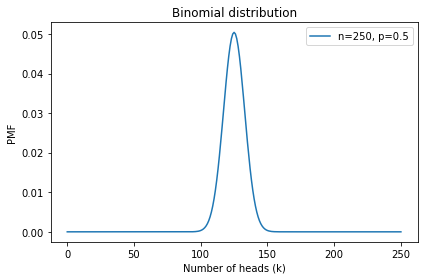

In [20]:
# calculate each of the k up to 250 total flips
pmf_k = make_binomial(n=250, p=0.5)

assert(sum(pmf_k) == 1)

pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution');

In [27]:
print(pmf_k.max_prob()) 
print(pmf_k[125])
print(prob_ge(pmf_k, 140))
print(pmf_k.prob_ge(140))
print(pmf_k.prob_le(110))

125
0.050412213147309655
0.033210575620021644
0.033210575620021644
0.033210575620021644


#### Findings:

When using the Binomial distribution the most likely number of flips is 125 at 5% of the time.

The 7% estimate comes from the concept of "as extreme as" 140, which could mean +15 from mean of 125 or -15 from mean. We can see find the cumulative probabilities of 140 - 250 and sum with 0-110 to get the likelihood of such an extreme value, about 6.6% 


### Bayesian Estimation:

There does exist some probability `x` of a coin landing heads when spun: 
- reasonable to believe that `x` depends on physical characteristic s like distribution of weight
- if perfectly balanced we expect `x` to be near 50%
- a lopsided coin might deviate from 50% for `x`

#### Uniform Prior

- assumes all values of `x` are equally likely, which of course is not a reasonable assumption

In [31]:
# build uniform prior of x 0 - 1.0
hypos = np.linspace(0,1,101)
prior = Pmf(1, hypos)

# build the associated likelihood based on hypothesis
likelihood_heads = hypos
likelihood_tails = 1 - hypos

# add into a dict: key is flip side
# value is vector of likelihood in order of hypotheses 
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

# data we see (order doesn't matter here)
dataset = 'H' * 140 + 'T' * 110

#### Update With Lots of Data:

Concept:
- iterate over each bit of data and update our pmf 
    - when we see a "H" our pmf is impacted by the vector of "likelihood_heads", which will update the mass in the positive direction (assuming a 1 means we flip heads eveytime)
    
- Our initial run is impacted by our prior, but as we get more and more data the weight of the prior is diminished. 
    - This makes sense - data that deviates from pre-established views (e.g. subjective prior) should more impact posterior as volume increases.
    
- normalization occurs after all data comes through

- added in a step to print max prob just to see how posterior shifts. 
    - initially uniform, but we should see greater values since we start with all Heads, and this will diminish as we start seeing Tails come in

In [54]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    i = 0
    for data in dataset:
        
        if i % 20 == 0:
            print(f"Step {i} max prob is at: {pmf.max_prob()}")
        pmf *= likelihood[data]
        i += 1

    pmf.normalize()

In [55]:
posterior = prior.copy()
update_euro(posterior, dataset)

Step 0 max prob is at: 0.0
Step 20 max prob is at: 1.0
Step 40 max prob is at: 1.0
Step 60 max prob is at: 1.0
Step 80 max prob is at: 1.0
Step 100 max prob is at: 1.0
Step 120 max prob is at: 1.0
Step 140 max prob is at: 1.0
Step 160 max prob is at: 0.87
Step 180 max prob is at: 0.78
Step 200 max prob is at: 0.7000000000000001
Step 220 max prob is at: 0.64
Step 240 max prob is at: 0.58


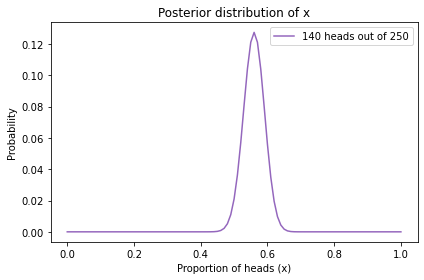

In [51]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)
    
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

#### Takeaways:

- The weight of data on posterior increases as volume of data inceases
- Can see the impact of new data to posterior above, such as when we first start seeing tails by step 160 (141 would be our first tails)
- Final posterior estimate is 0.56, which is conveniently the proportion of heads in our dataset (`140/250`)

### Adjusting the Prior:

Using a triangle prior:
- A completely uniform prior might not make sense, since we may assume 0.4-0.6 more likely than 0.1 or 0.9.


In [56]:
# triangle prior:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

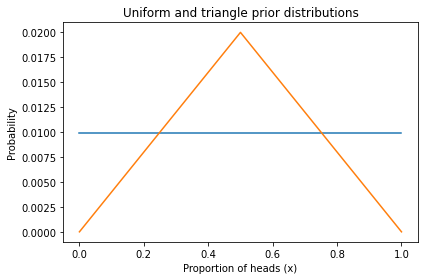

In [58]:

# rebuild uniform:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

# view priors:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

In [63]:
triangle.tail()

,probs
0.98,1.324197e-116
0.99,2.113001e-149
1.00,0.000000e+00


In [59]:
# run update for each - very minor differences throughout 
# triangle never hits 1.0 for max since the prior has 1.0 at 0 
update_euro(uniform, dataset)
update_euro(triangle, dataset)

Step 0 max prob is at: 0.0
Step 20 max prob is at: 1.0
Step 40 max prob is at: 1.0
Step 60 max prob is at: 1.0
Step 80 max prob is at: 1.0
Step 100 max prob is at: 1.0
Step 120 max prob is at: 1.0
Step 140 max prob is at: 1.0
Step 160 max prob is at: 0.87
Step 180 max prob is at: 0.78
Step 200 max prob is at: 0.7000000000000001
Step 220 max prob is at: 0.64
Step 240 max prob is at: 0.58
Step 0 max prob is at: 0.5
Step 20 max prob is at: 0.9500000000000001
Step 40 max prob is at: 0.98
Step 60 max prob is at: 0.98
Step 80 max prob is at: 0.99
Step 100 max prob is at: 0.99
Step 120 max prob is at: 0.99
Step 140 max prob is at: 0.99
Step 160 max prob is at: 0.87
Step 180 max prob is at: 0.77
Step 200 max prob is at: 0.7000000000000001
Step 220 max prob is at: 0.63
Step 240 max prob is at: 0.58


#### Takeaway:

Example of "swamping the priors" - with enough data we see different priors converge to the same posterior.

- In practice, using an uninformed or naive prior is not harmful assuming you get enough data (and how would we determine enough data in Bayesian world?)

- https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem

This does make me question some of the value of a prior, especially in our current work where we get thousands (at a minimum) of data points. 

What value does that prior actually provide in the case where we know we will get 10M observations?

### Updating At Once: 

- Rather than update after each spin we can compute the likelihood of the entire dataset at once. 
- This means using binomial distribution and computing probability of getting `140 heads out of 250 spins` given each hypothesis `x`

In [73]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [74]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

assert np.allclose(uniform, uniform2)

#### Why Does The Above Work? 

- The likelihood's end up being the same, I will walk through with a toy example below

In [92]:
hypos = np.linspace(0, 1, 5)
print(hypos)

likelihood_heads = hypos
likelihood_tails = 1 - hypos

likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

dataset = 'H' * 4 + 'T' * 1
val = np.asarray([1.0,1.0,1.0,1.0,1.0])
for data in dataset:
    val *= likelihood[data]

print(val)

# compare to single step
k, n = 4,5 # 4 heads, 5 total
xs = [0.  , 0.25, 0.5 , 0.75, 1.  ]
likelihood = binom.pmf(k, n, xs)
print(likelihood)

[0.   0.25 0.5  0.75 1.  ]
[0.         0.00292969 0.03125    0.07910156 0.        ]
[0.         0.01464844 0.15625    0.39550781 0.        ]


### Final Thoughts: 

- The above normalizes to the same value
- I followed this fully until the comment around the 